In [1]:
from trendAnalyserPy import StockTrendAnalyzer
from backtestPy import Backtester
from optimizerPy import Optimizer
import yfinance as yf
import numpy as np
import pandas as pd

In [26]:
class Trading:
    def __init__(self, symbol, start_date, end_date, interval, period=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.period = period

        # Initialize the detector with properly loaded data
        self.stock = self._load_data()
        self.detector = StockTrendAnalyzer(symbol, start_date, end_date, self.stock, interval, period)
        self.backtester = Backtester(self.stock)
        self.optimizer = Optimizer(self.backtester)

    def _load_data(self):
        """
        Load stock data, considering intraday intervals with period and start_date.
        """
        if self.interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']:  # Intraday intervals
            stock = yf.download(self.symbol, period=self.period, interval=self.interval)
            stock.reset_index(inplace=True)
            stock.rename(columns={'Datetime': 'Date'}, inplace=True)
            
            # Filter by start_date
            stock['Date'] = pd.to_datetime(stock['Date'])
            stock = stock[stock['Date'] >= pd.to_datetime(self.start_date)]
        else:  # Daily or higher intervals
            stock = yf.download(self.symbol, start=self.start_date, end=self.end_date, interval=self.interval)
            stock.columns = stock.columns.droplevel(1)

        print("Data loaded successfully.")
        return stock

    def analyze_stock(self):
        """
        Analyze stock trends for the initialized symbol and time period.
        """
        analyzer = self.detector
        analyzer.data = self.stock  # Ensure detector works with the loaded data
        analyzer.find_peaks_and_troughs()
        analyzer.identify_trends()
        
        # Generate visualization
        plt = analyzer.visualize_trends()
        plt.show()
        
        # Print trend summary
        print(f"\nTrend Summary for {self.symbol}:")
        for summary in analyzer.get_trend_summary():
            print(summary)
        
        return analyzer

    def backtest(self, strategy, **params):
        """
        Backtest a trading strategy using the stock data.
        """
        backtester = Backtester(self.data)
        return backtester.backtest(strategy, **params)

    def optimize(self, strategy, param_ranges, initial_guess):
        """
        Optimize trading strategy parameters.
        """
        backtester = Backtester(self.data)
        optimizer = Optimizer(backtester)
        return optimizer.optimize(strategy, param_ranges, initial_guess)


[*********************100%***********************]  1 of 1 completed


Data loaded successfully.


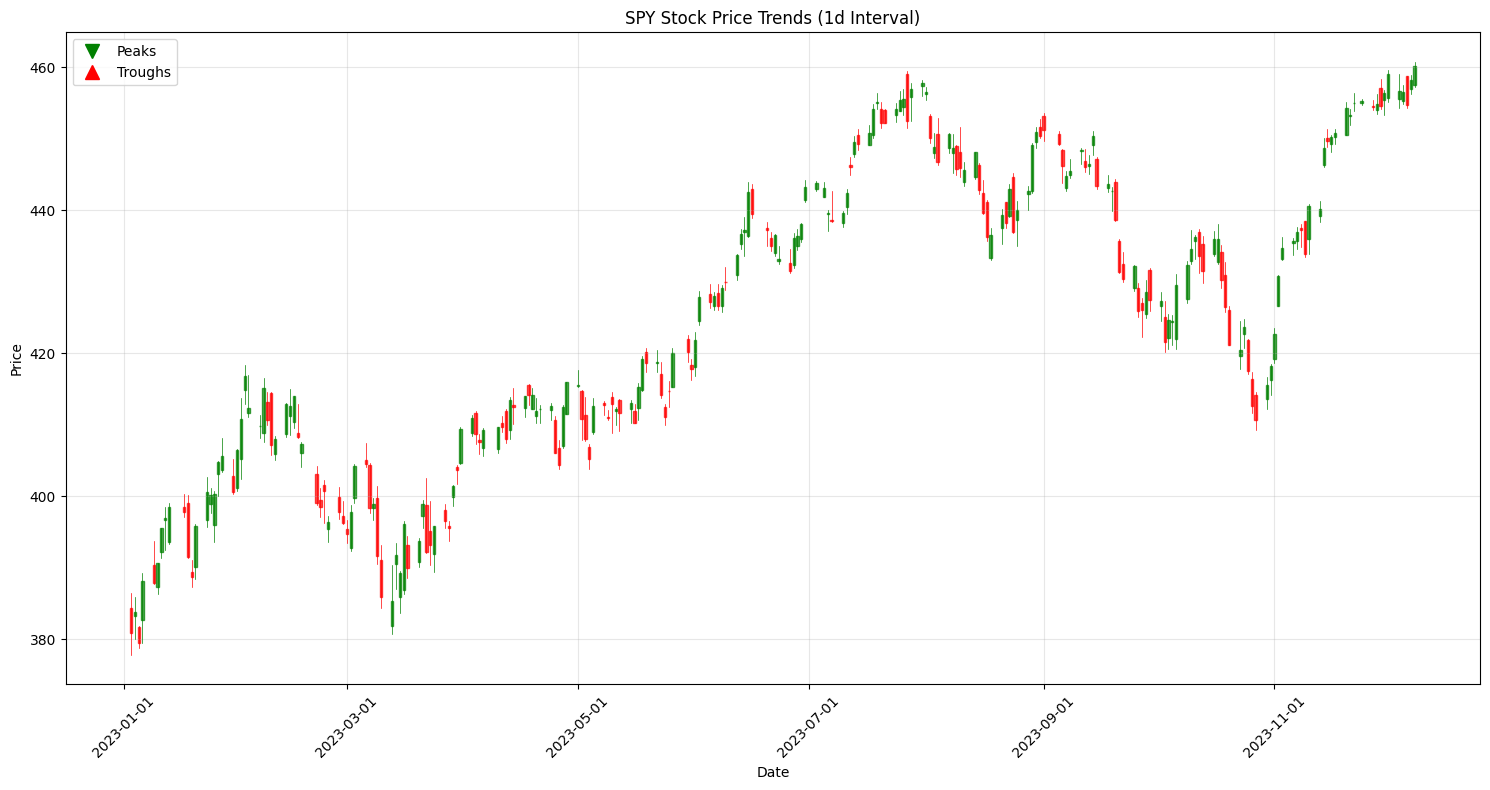


Trend Summary for SPY:


In [27]:
symbol='SPY'
start_date='2023-01-03' 
end_date='2023-12-10'
period='1d'
interval='1d'
trading = Trading(symbol, start_date, end_date, interval=interval, period=period)
analyzer = trading.analyze_stock()

In [ ]:
trading.stock.drop(columns=["Ticker"])